# Question 4: Can you detect Cascading Failures as delays in one airport create delays in others

### Import Neccessary Libraries

In [89]:

import pandas as pd
from datetime import datetime
import sqlite3 as sqlite3
import pyarrow as pa
import pyarrow.csv as pcsv
import matplotlib.pyplot as plt
import igraph as ig
import numpy as np
import seaborn as sns




### Read the data and Connect to the Database


In [2]:


# Read the data
d1 = pcsv.read_csv("D:/R files/2004.csv").to_pandas()
d2 = pcsv.read_csv("D:/R files/2005.csv").to_pandas()
d3 = pcsv.read_csv("D:/R files/2006.csv").to_pandas()
plane_data = pd.read_csv("D:/R files/plane-data.csv")
airports = pcsv.read_csv("D:/R files/airports.csv").to_pandas()

# Connect to database
conn = sqlite3.connect("Coursework_1234.db")
c = conn.cursor()

# Remove table if it exists
c.execute('''DROP TABLE IF EXISTS d36''')
# Remove table if it exists
c.execute('''DROP TABLE IF EXISTS airports''')

# Remove table if it exists
c.execute('''DROP TABLE IF EXISTS plane_data''')

#use .to_sql to create the tables and data from jupyter to SQL
airports.to_sql('airports', con = conn, index = False)
plane_data.to_sql('plane_data',con=conn,index=False)
d1.to_sql('d36', conn, if_exists='append', index=False)
d2.to_sql('d36', conn, if_exists='append', index=False)
d3.to_sql('d36', conn, if_exists='append', index=False)



7141922

In [3]:
query = c.execute('''
SELECT Year, Month,DayOfMonth,Origin,Dest,ArrDelay,DepDelay
FROM d36 
''').fetchall()

In [4]:
#changing query from a list to a dataframe which will be used for plotting graphs
flights= (pd.DataFrame(query, columns = ['Year','Month','Day','Origin','Dest','ArrDelay','DepDelay'])) 

In [5]:
# Creating date column from columns 'Year','Month','Day'
flights['date'] = pd.to_datetime(flights[['Year', 'Month', 'Day']], format='%Y%m%d')


In [6]:

# Create a network of airports
airports = pd.unique(flights[['Origin', 'Dest']].values.ravel('K'))
edges = flights[['Origin', 'Dest']].drop_duplicates()
g = ig.Graph.TupleList(edges.itertuples(index=False), directed=True)
g.add_vertices(airports)


# Analyze the network structure
betweenness = g.betweenness()
centrality = pd.DataFrame({'name': g.vs['name'], 'betweenness': betweenness})
top_airports = centrality.nlargest(10, 'betweenness')

# Collect data on flight delays and cancellations
airport_data = flights.groupby('Origin').agg(num_flights=('Origin', 'count'),
                                             avg_delay=('ArrDelay', 'mean'),
                                             num_delays=('ArrDelay', lambda x: (x > 0).sum()))


# Plot the network
ig.plot(g, vertex_size=2, vertex_label='', edge_arrow_size=0.2, margin=10)

In [43]:
for airport in top_airports['name']:
    g_copy = g.copy()
    g_copy.delete_vertices(g.vs.find(name=airport)['name'])
    print(f"Removed {airport}, number of connected components: {len(g_copy.clusters(mode='WEAK'))}")


Removed ATL, number of connected components: 322
Removed DFW, number of connected components: 313
Removed SLC, number of connected components: 313
Removed ORD, number of connected components: 311
Removed IAH, number of connected components: 313
Removed ANC, number of connected components: 313
Removed CVG, number of connected components: 311
Removed DEN, number of connected components: 312
Removed MSP, number of connected components: 312
Removed LAX, number of connected components: 310


C:\Users\musad\AppData\Local\Temp\ipykernel_23220\2822220378.py:4: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  print(f"Removed {airport}, number of connected components: {len(g_copy.clusters(mode='WEAK'))}")


In [34]:
#Top airport betweenness 
top_airports


,name,betweenness
39,ATL,20054.756528
22,DFW,10288.937592
45,SLC,9089.107208
0,ORD,8474.909231
26,IAH,7811.210258
72,ANC,6879.399983
35,CVG,6413.586746
5,DEN,5678.512431
18,MSP,4181.201084
12,LAX,3905.203112


In [62]:
# Get unique names in the "Origin" column
names = top_airports['name'].unique()

# Loop through each name and create a dataframe
for name in names:
    # Filter the data by the current name
    df_filtered = flights[flights['Origin'] == name].groupby(['date', 'Origin'], as_index=False)['DepDelay'].mean()

    po = flights[flights['Origin'] == name]['Dest'].unique()

    # Filter the data by the current name
    df_filtered_ = flights[flights['Origin'].isin(po)].groupby(['date', 'Origin'], as_index=False)['DepDelay'].mean()

    df_filtered.rename(columns={'DepDelay': 'delay_'}, inplace=True)
    df_filtered_.rename(columns={'DepDelay': 'delay'}, inplace=True)
    df_filtered[name] = df_filtered['delay_']
    df_filtered.drop(columns=['delay_'], inplace=True)
    new_data = pd.pivot_table(df_filtered_, values='delay', index=['date'], columns=['Origin'])

    df_filtered_1 = pd.merge(df_filtered, new_data, on='date')

    exec(f"delay_{name} = df_filtered_1")

# Create an empty list to store data frames
dfs = []

# Loop through each airport
for airport in ["ORD", "DEN","DFW", "IAH","ATL", "LAX","MSP", "SLC","ANC", "CVG"]:

    # Get the delay data for the current airport
    delay_data = locals()[f"delay_{airport}"]

    # Create an empty data frame to store results
    results_df = pd.DataFrame(columns=['Correlation', 'Airport_to', 'Airport_from'])
    ## Convert non-numeric values to NaN
    #delay_data = delay_data.apply(pd.to_numeric, errors='coerce')
    # Loop through each city and calculate correlation
    for city in delay_data.columns[2:]:
        x = np.nan_to_num(delay_data.iloc[:,2])
        y=np.nan_to_num(delay_data[city])
        mask = np.isfinite(x) & np.isfinite(y)
        corr = np.corrcoef(x[mask], y[mask])[0, 1]
        if np.isnan(corr):
            continue
        if 0.60 < corr < 1:
            new_row = pd.DataFrame({'Correlation': corr, 'Airport_to': city, 'Airport_from': airport}, index=[0])
            results_df = pd.concat([results_df, new_row])

    # Add results data frame to the list
    dfs.append(results_df)

# Combine data frames using pd.concat
final_df = pd.concat(dfs)


print(final_df)





D:\musad\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
D:\musad\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


    Correlation Airport_to Airport_from
0      0.618033        AZO          ORD
0      0.603709        BMI          ORD
0      0.614967        BNA          ORD
0      0.692870        CID          ORD
0      0.641646        CMH          ORD
..          ...        ...          ...
0      0.742576        CLE          CVG
0      0.636406        CMH          CVG
0      0.659964        DAY          CVG
0      0.651827        IND          CVG
0      0.638647        SDF          CVG

[94 rows x 3 columns]


D:\musad\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
D:\musad\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [67]:
# Filter only correlation higher than 0.60
final_df=final_df.loc[(final_df['Airport_to']!=final_df['Airport_from'])&final_df['Correlation']>0.60,]



In [68]:
# assuming the data is in a DataFrame named 'correlations' Get top 5 Correlations
top_correlations = (
    final_df
    .groupby('Airport_from')
    .apply(lambda x: x.nlargest(5, 'Correlation'))
    .reset_index(drop=True)
)

In [70]:
top_correlations

,Correlation,Airport_to,Airport_from
0,0.624073,FAI,ANC
1,0.725940,SRQ,ATL
2,0.714932,SAV,ATL
3,0.710206,PNS,ATL
4,0.708056,TLH,ATL
5,0.696219,MLB,ATL
6,0.742576,CLE,CVG
7,0.659964,DAY,CVG
8,0.651827,IND,CVG
9,0.638647,SDF,CVG


C:\Users\musad\AppData\Local\Temp\ipykernel_1700\3516125921.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = top_correlations.pivot('Airport_to', 'Airport_from', 'Correlation')


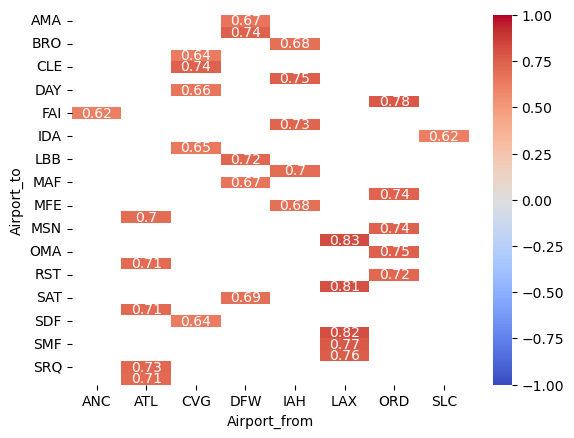

In [87]:
# create pivot table
pivot_df = top_correlations.pivot('Airport_to', 'Airport_from', 'Correlation')

# create heatmap
#sns.heatmap(pivot_df, annot=True,fmt='.2f', cmap='coolwarm',annot_kws={'verticalalignment': 'center'})
# plot the heatmap
sns.heatmap(pivot_df, cmap="coolwarm", annot=True, vmin=-1, vmax=1)

# set x and y labels
plt.xlabel('Airport_from')
plt.ylabel('Airport_to')

# show plot
plt.show()